#### Now integrating drone mechanisms ...

In [ ]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import norm
from scipy.special import ndtr
from matplotlib import pyplot as plt
from matplotlib.path import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    Matern,
    ConstantKernel as C,
    WhiteKernel,
)
from dataclasses import dataclass

# Environment and State classes
@dataclass(frozen=True)
class FireEnv:
    grid_size: tuple[int, int]
    domain_km: float
    fuel: np.ndarray          # (nx, ny)
    value: np.ndarray          # (nx, ny)
    wind: np.ndarray           # (T, nx, ny, 2) or (nx, ny, 2) if constant
    dt_s: float                # seconds per CA step
    burn_time_s0: float = 600.0       # initial burn time per cell in seconds
    retardant_half_life_s: float = 1800.0  # seconds
    retardant_k: float = 1.0              # strength in exp(-k * retardant) that downscales hazard in cell with retardant

    drop_w_km: float = 0.2                 # width of retardant drop
    drop_h_km: float = 1                # height of retardant drop
    drop_amount: float = 1.0    # amount of retardant per drop (peak concentration)

    ros_mps: float = 0.5          # baseline rate of spread in m/s, 
    wind_coeff: float = 0.6,      # wind alignment boost strength
    diag: bool = True            # whether diagonal spread is allowed

@dataclass
class FireState:
    burning: np.ndarray        # (..., nx, ny) bool  (batch dim optional)
    burned: np.ndarray         # (..., nx, ny) bool
    burn_remaining_s: np.ndarray   # (..., nx, ny) float
    retardant: np.ndarray          # (n_sims, nx, ny) float
    t: int = 0

######## Fire Boundary Extraction ########

@dataclass(frozen=True)
class FireBoundary:
    t: int
    p_boundary: float
    s: np.ndarray      # (K,) uniform in [0,1)
    xy: np.ndarray     # (K,2) points (x_cell, y_cell)
    closed: bool = True

def _polyline_length(xy: np.ndarray) -> float:
    d = np.diff(xy, axis=0)
    return float(np.sum(np.hypot(d[:, 0], d[:, 1])))

def _signed_area(xy: np.ndarray) -> float:
    x, y = xy[:, 0], xy[:, 1]
    return 0.5 * float(np.sum(x[:-1] * y[1:] - x[1:] * y[:-1]))

def _resample_closed_polyline(xy: np.ndarray, K: int) -> np.ndarray:
    if not np.allclose(xy[0], xy[-1]):
        xy = np.vstack([xy, xy[0]])

    d = np.diff(xy, axis=0)
    seg = np.hypot(d[:, 0], d[:, 1])
    L = float(np.sum(seg))
    if L <= 1e-12:
        raise ValueError("Boundary contour has near-zero length.")

    cum = np.concatenate([[0.0], np.cumsum(seg)])  # (M+1,)
    s_targets = np.linspace(0.0, L, K, endpoint=False)

    x = np.interp(s_targets, cum, xy[:, 0])
    y = np.interp(s_targets, cum, xy[:, 1])
    return np.stack([x, y], axis=1)

def extract_fire_boundary(
    firestate,
    *,
    K: int,
    p_boundary: float = 0.5,
    field: str = "affected",   # "affected" | "burning" | "burned"
    anchor: str = "max_x",     # deterministic starting point
    ccw: bool = True,
) -> FireBoundary:
    burning = firestate.burning[0]
    burned  = firestate.burned[0]

    is_prob = np.issubdtype(burning.dtype, np.floating) or np.issubdtype(burned.dtype, np.floating)

    if field == "burning":
        p = burning.astype(float) if not is_prob else np.clip(burning, 0.0, 1.0)
    elif field == "burned":
        p = burned.astype(float) if not is_prob else np.clip(burned, 0.0, 1.0)
    elif field == "affected":
        p = (burning | burned).astype(float) if not is_prob else np.clip(burning + burned, 0.0, 1.0)
    else:
        raise ValueError(f"Unknown field={field}")

    # Contour on p.T so vertices are in (x_cell, y_cell) consistent with your imshow(p.T, origin="lower")
    fig = plt.figure()
    try:
        CS = plt.contour(p.T, levels=[p_boundary])

        # Robust extraction across matplotlib variants
        if hasattr(CS, "allsegs") and len(CS.allsegs) > 0:
            segs = CS.allsegs[0]  # list of (N_i, 2) arrays for this level
        elif hasattr(CS, "collections") and CS.collections:
            segs = []
            for path in CS.collections[0].get_paths():
                segs.append(path.vertices)
        else:
            segs = []
    finally:
        plt.close(fig)

    segs = [s for s in segs if isinstance(s, np.ndarray) and s.shape[0] >= 3]
    if not segs:
        raise ValueError(f"No boundary found for level p_boundary={p_boundary}. Try a different level.")

    xy0 = max(segs, key=_polyline_length)

    # close
    if not np.allclose(xy0[0], xy0[-1]):
        xy0 = np.vstack([xy0, xy0[0]])

    # orientation
    if ccw and _signed_area(xy0) < 0:
        xy0 = xy0[::-1].copy()
    if (not ccw) and _signed_area(xy0) > 0:
        xy0 = xy0[::-1].copy()

    # resample to K arc-length-uniform points
    xyK = _resample_closed_polyline(xy0, K)

    # deterministic anchor
    if anchor == "max_x":
        i0 = int(np.argmax(xyK[:, 0]))
    elif anchor == "min_x":
        i0 = int(np.argmin(xyK[:, 0]))
    elif anchor == "max_y":
        i0 = int(np.argmax(xyK[:, 1]))
    elif anchor == "min_y":
        i0 = int(np.argmin(xyK[:, 1]))
    else:
        raise ValueError(f"Unknown anchor={anchor}")

    xyK = np.roll(xyK, -i0, axis=0)
    s = np.linspace(0.0, 1.0, K, endpoint=False)

    return FireBoundary(t=int(firestate.t), p_boundary=float(p_boundary), s=s, xy=xyK, closed=True)

def plot_fire_boundary(
    firestate,
    boundary,                 # FireBoundary from extract_fire_boundary
    *,
    field: str = "affected",  # "affected" | "burning" | "burned"
    title: str | None = None,
    show_points: bool = True,
):
    """
    Overlay the boundary (K points) on the underlying probability field.
    """
    burning = firestate.burning[0]
    burned  = firestate.burned[0]

    is_prob = np.issubdtype(burning.dtype, np.floating) or np.issubdtype(burned.dtype, np.floating)

    if field == "burning":
        p = burning.astype(float) if not is_prob else np.clip(burning, 0.0, 1.0)
        cbar = "P(burning)"
    elif field == "burned":
        p = burned.astype(float) if not is_prob else np.clip(burned, 0.0, 1.0)
        cbar = "P(burned)"
    elif field == "affected":
        p = (burning | burned).astype(float) if not is_prob else np.clip(burning + burned, 0.0, 1.0)
        cbar = "P(affected)"
    else:
        raise ValueError(f"Unknown field={field}")

    plt.figure(figsize=(6, 5))
    im = plt.imshow(p.T, origin="lower", vmin=0.0, vmax=1.0, aspect="equal")
    plt.colorbar(im, label=cbar)

    xy = boundary.xy
    plt.plot(xy[:, 0], xy[:, 1], linewidth=2, label=f"p={boundary.p_boundary:g} contour",color='tab:red')

    if show_points:
        plt.scatter(xy[:, 0], xy[:, 1], s=10)

    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.title(title if title is not None else f"Fire boundary at t={boundary.t}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def between_boundaries_mask(boundary0_xy, boundary1_xy, grid_size):
    """
    Returns a boolean mask (nx,ny) that is True for cells whose centres lie
    in the region between the two closed curves (assumes one encloses the other).
    """
    nx, ny = grid_size

    X = np.arange(nx)[:, None]
    Y = np.arange(ny)[None, :]
    pts = np.stack([np.broadcast_to(X, (nx, ny)).ravel(),
                    np.broadcast_to(Y, (nx, ny)).ravel()], axis=1)

    path0 = Path(boundary0_xy, closed=True)
    path1 = Path(boundary1_xy, closed=True)

    inside0 = path0.contains_points(pts).reshape(nx, ny)
    inside1 = path1.contains_points(pts).reshape(nx, ny)

    # pick outer/inner by area (count of inside cells)
    if inside0.sum() >= inside1.sum():
        outer, inner = inside0, inside1
    else:
        outer, inner = inside1, inside0

    return outer & (~inner)

def candidates_from_mask(mask, *, stride=1):
    """
    Convert a mask into an explicit list of candidate (x,y) cell coordinates.
    stride>1 coarsens the candidate set (useful if region is still large).
    """
    xs, ys = np.where(mask)
    if stride > 1:
        keep = (xs % stride == 0) & (ys % stride == 0)
        xs, ys = xs[keep], ys[keep]
    return np.stack([xs.astype(float), ys.astype(float)], axis=1)  # (N,2)

##### Cellular Automaton Fire Model ####
class CAFireModel:
    def __init__(self, env: FireEnv, seed: int | None = None):
        self.env = env
        self.base_seed = seed

        nx, _ = env.grid_size
        self.dx = self.env.domain_km / nx 
        self.dx_m = self.dx * 1000.0 # in meters

    def init_state_batch(self, n_sims: int, center, radius_km: float) -> FireState:
        nx, ny = self.env.grid_size
        radius_cells = int(radius_km / self.dx) 
        
        x = np.arange(nx)[:, None]
        y = np.arange(ny)[None, :]
        cx, cy = center
        mask2d = (x - cx) ** 2 + (y - cy) ** 2 <= radius_cells ** 2

        burning = np.zeros((n_sims, nx, ny), dtype=bool)
        burning[:, mask2d] = True

        burned = np.zeros((n_sims, nx, ny), dtype=bool)

        burn_remaining_s = np.broadcast_to(self.env.burn_time_s0, (n_sims, nx, ny)).copy()

        retardant = np.zeros((n_sims, nx, ny), dtype=float)
        return FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, t=0, retardant=retardant)

    @staticmethod
    def _shift_no_wrap(a: np.ndarray, sx: int, sy: int) -> np.ndarray:
        # a: (n_sims, nx, ny)
        n_sims, nx, ny = a.shape
        out = np.zeros_like(a)

        x_from0 = max(0, -sx)
        x_from1 = min(nx, nx - sx)
        y_from0 = max(0, -sy)
        y_from1 = min(ny, ny - sy)

        x_to0 = max(0, sx)
        x_to1 = min(nx, nx + sx)
        y_to0 = max(0, sy)
        y_to1 = min(ny, ny + sy)

        if x_from0 < x_from1 and y_from0 < y_from1:
            out[:, x_to0:x_to1, y_to0:y_to1] = a[:, x_from0:x_from1, y_from0:y_from1]
        return out

    def step_batch(
        self,
        state: FireState,
        *,
        ros_mps: float = 0.5,
        wind_coeff: float = 0.5,
        diag: bool = True,
    ):
        env = self.env
        dt_s = float(env.dt_s)
        dx_m = float(self.dx_m)

        burning = state.burning
        burned = state.burned

        # RNG
        seed = None if self.base_seed is None else (self.base_seed + state.t)
        rng = np.random.default_rng(seed)

        # -------------------------
        # 0) Retardant decay (half-life)
        # r <- r * exp(-ln(2) * dt / half_life)
        # -------------------------
        hl = float(env.retardant_half_life_s)
        if hl > 0.0:
            decay = np.exp(-np.log(2.0) * dt_s / hl)
            state.retardant *= decay

        # -------------------------
        # 1) Burnout dynamics
        # -------------------------
        state.burn_remaining_s[burning] = np.maximum(0.0, state.burn_remaining_s[burning] - dt_s)
        newly_burned = burning & (state.burn_remaining_s <= 0.0)
        burned[newly_burned] = True
        burning[newly_burned] = False

        if not np.any(burning):
            state.t += 1
            return

        unburned = ~(burning | burned)

        # 2) Wind at time t
        w = env.wind[state.t] if env.wind.ndim == 4 else env.wind
        wx = w[..., 0][None, :, :]
        wy = w[..., 1][None, :, :]

        # 3) Fuel multiplier
        fuel_mul = env.fuel[None, :, :]

        # 4) Baseline hazard
        lambda0 = ros_mps / dx_m  # 1/s

        # 5) Neighborhood
        if diag:
            dirs = [(1, 0), (-1, 0), (0, 1), (0, -1),
                    (1, 1), (1, -1), (-1, 1), (-1, -1)]
        else:
            dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        prob_no = np.ones_like(state.burn_remaining_s, dtype=float)

        # -------------------------
        # Retardant effectiveness: attenuate hazard at target cell
        # lambda_dir *= exp(-k * retardant)
        # -------------------------
        k = float(env.retardant_k)
        retardant_attn = np.exp(-k * np.maximum(state.retardant, 0.0))  # (n_sims,nx,ny) in (0,1]

        for sx, sy in dirs:
            src = self._shift_no_wrap(burning, sx, sy)
            if not np.any(src):
                continue

            dist = float(np.hypot(sx, sy))
            ux, uy = sx / dist, sy / dist

            align = wx * ux + wy * uy
            bias = 1.0 + wind_coeff * np.maximum(0.0, align)

            lambda_dir = (lambda0 / dist) * fuel_mul * bias
            lambda_dir = lambda_dir * retardant_attn 

            p_dir = 1.0 - np.exp(-lambda_dir * dt_s)
            p_dir = np.clip(p_dir, 0.0, 1.0)

            prob_no *= np.where(src, (1.0 - p_dir), 1.0)

        ignite_prob = np.clip(1.0 - prob_no, 0.0, 1.0)
        u = rng.random(size=ignite_prob.shape)
        newly_ignited = unburned & (u < ignite_prob)

        if np.any(newly_ignited):
            burning[newly_ignited] = True
            state.burn_remaining_s[newly_ignited] = float(env.burn_time_s0)

        state.t += 1


    def simulate_burned_probability(
        self,
        T: int,
        n_sims: int,
        center,
        radius_km: float,
        *,
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,

    ) -> np.ndarray:
        """
        Returns p_affected[x,y] = P(cell is burning OR burned by time T starting from t=0 ignition).
        - n_sims: number of Monte Carlo simulations to run.
        - center: (x,y) cell coordinates of ignition center.
        - radius_km: ignition radius in kilometers.
        - ros_mps: baseline rate of spread in m/s.
        - wind_coeff: wind alignment boost strength.
        - diag: whether diagonal spread is allowed.
        - T: total simulation time in seconds.
        - returns: p_affected[x,y] in [0,1]
        """

        state = self.init_state_batch(n_sims=n_sims, center=center, radius_km=radius_km)

        num_steps = int(T/self.env.dt_s)
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        p_affected = (state.burned | state.burning).mean(axis=0)  # (nx, ny) in [0,1]
        return p_affected

    def aggregate_mc_to_state(self,batch_state: FireState) -> FireState:
        """
        Aggregate a batched Monte Carlo FireState -> a single FireState containing probabilities.

        Input:
        batch_state.burning, batch_state.burned: (n_sims,nx,ny) bool
        batch_state.burn_remaining_s:            (n_sims,nx,ny) float

        Output (single-sim state):
        burning[0]: p(burning) in [0,1]
        burned[0]:  p(burned)  in [0,1]
        burn_remaining_s[0]: E[burn_remaining_s | burning] (0 where p(burning)=0)

        Note: this aggregated FireState is for analysis/plotting, not as input to step_batch().
        """
        burning_bool = batch_state.burning
        burned_bool  = batch_state.burned

        p_burning = burning_bool.mean(axis=0)   # (nx,ny)
        p_burned  = burned_bool.mean(axis=0)    # (nx,ny)

        # Conditional mean remaining time among burning cells
        burn_sum = (batch_state.burn_remaining_s * burning_bool).sum(axis=0)
        burn_cnt = burning_bool.sum(axis=0).astype(float)
        burn_mean_cond = np.divide(
            burn_sum, burn_cnt,
            out=np.zeros_like(burn_sum, dtype=float),
            where=(burn_cnt > 0),
        )

        r_mean = batch_state.retardant.mean(axis=0)

        return FireState(
            burning=p_burning[None, :, :],
            burned=p_burned[None, :, :],
            burn_remaining_s=burn_mean_cond[None, :, :],
            retardant=r_mean[None, :, :],
            t=batch_state.t,
    )

    def extract_fire_boundary(
        self,
        firestate,
        *,
        K: int,
        p_boundary: float = 0.5,
        field: str = "affected",   # "affected" | "burning" | "burned"
        anchor: str = "max_x",     # deterministic starting point
        ccw: bool = True,
    ) -> FireBoundary:
        return extract_fire_boundary(
            firestate,
            K=K,
            p_boundary=p_boundary,
            field=field,
            anchor=anchor,
            ccw=ccw
        )

    def plot_fire_boundary(
        self,
        firestate,
        boundary,                 # FireBoundary from extract_fire_boundary
        *,
        field: str = "affected",  # "affected" | "burning" | "burned"
        title: str | None = None,
        show_points: bool = True,
    ):
        """
        Overlay the boundary (K points) on the underlying probability field.
        """
        return plot_fire_boundary(
            firestate,
            boundary,
            field=field,
            title=title,
            show_points=show_points
        )

    def discretise_between_boundaries(
        self,
        init_fire_boundary: FireBoundary,
        final_fire_boundary: FireBoundary,
    ) -> np.ndarray:
        """
        Returns a boolean mask (nx,ny) that is True for cells whose centres lie
        in the region between the two closed curves (assumes one encloses the other).
        """
        return between_boundaries_mask(init_fire_boundary.xy, final_fire_boundary.xy, self.env.grid_size)

    def plot_search_domain(
        self,
        discrete_grid_between_boundaries: np.ndarray,
    ):
        plt.figure(figsize=(6, 6))
        im = plt.imshow(discrete_grid_between_boundaries.T, origin="lower", aspect="equal")
        plt.colorbar(im, label="Search Domain (Between Fire Boundaries)")
        plt.xlabel("x cell")
        plt.ylabel("y cell")
        plt.title("Region Between Fire Boundaries")
        plt.tight_layout()
        plt.show()

    def apply_retardant_cartesian(
        self,
        state: FireState,
        drone_params: np.ndarray | None,
        *,
        drop_w_km: float,
        drop_h_km: float,
        amount: float = 1.0,
    ):
        """
        Add D oriented rectangular retardant drops into state.retardant (in-place).

        drone_params: array of shape (D, 3) with rows (x_i, y_i, phi_i)
        - x_i, y_i in cell coordinates (floats allowed)
        - phi_i in radians, phi=0 => vertical (height along +y)

        drop_w_km / drop_h_km: rectangle width/height in km
        amount: additive retardant load per cell inside each rectangle

        Uses cartesian coordinates for retardant drop placement.
        """
        if drone_params is None:
            return

        drone_params = np.asarray(drone_params, dtype=float)
        if drone_params.size == 0:
            return
        if drone_params.ndim != 2 or drone_params.shape[1] != 3:
            raise ValueError(f"drone_params must have shape (D,3); got {drone_params.shape}")

        n_sims, nx, ny = state.retardant.shape

        # Convert km -> cells
        half_w = 0.5 * (drop_w_km / self.dx)
        half_h = 0.5 * (drop_h_km / self.dx)

        # Coordinate grid in cell indices
        X = np.arange(nx)[:, None]  # (nx,1)
        Y = np.arange(ny)[None, :]  # (1,ny)

        for x0, y0, phi in drone_params:
            xp = X - x0
            yp = Y - y0

            c = np.cos(phi)
            s = np.sin(phi)

            # Rotate points by -phi into rectangle's local frame
            xr = c * xp + s * yp
            yr = -s * xp + c * yp

            mask = (np.abs(xr) <= half_w) & (np.abs(yr) <= half_h)  # (nx,ny)

            # Apply same drop to all sims
            state.retardant[:, mask] += amount

    def simulate_from_ignition(
        self,
        T: int,
        n_sims: int,
        center,
        radius_km: float,
        *,
        drone_params: np.ndarray | None = None,  #Cartesian params
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,

    ) -> np.ndarray:
        """
        Same as above simulate_burned_probability, but returns the entire aggregated FireState snapshot for downstream use.
        """

        state = self.init_state_batch(n_sims=n_sims, center=center, radius_km=radius_km)

        self.apply_retardant_cartesian(
            state,
            drone_params,
            drop_w_km=self.env.drop_w_km,
            drop_h_km=self.env.drop_h_km,
            amount=self.env.drop_amount,
        )

        num_steps = int(T/self.env.dt_s)
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        updated_firestate = self.aggregate_mc_to_state(state)
        return updated_firestate

    def simulate_from_firestate(
        self,
        init_firestate: FireState,
        T: float,
        n_sims: int,
        *,
        drone_params: np.ndarray | None = None,  #Cartesian params
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,
        seed: int | None = None,
    ) -> FireState:
        """
        Simulate forward for T seconds starting from init_firestate, using n_sims MC runs,
        then return the aggregated FireState (probability maps).

        - If init_firestate is boolean (a concrete state / batch of states), we replicate/tile to n_sims.
        - If init_firestate is probabilistic (aggregated; float), we sample an n_sims boolean ensemble.

        NOTE: We re-sample n_sims from the distribution defined by the init_firestate (i.e. MC noise is present at t=0) to intialise each batched run.
        """
        nx, ny = self.env.grid_size
        dt_s = float(self.env.dt_s)
        num_steps = int(np.ceil(float(T) / dt_s))

        if seed is None:
            seed = None if getattr(self, "base_seed", None) is None else (self.base_seed + int(init_firestate.t))
        rng = np.random.default_rng(seed)

        def _ensure_batched(arr, dtype=None):
            a = np.asarray(arr)
            if dtype is not None:
                a = a.astype(dtype, copy=False)
            if a.ndim == 2:
                a = a[None, :, :]
            if a.shape[1:] != (nx, ny):
                raise ValueError(f"Expected shape (*,{nx},{ny}), got {a.shape}")
            return a

        burning0 = _ensure_batched(init_firestate.burning)
        burned0  = _ensure_batched(init_firestate.burned)
        br0      = _ensure_batched(init_firestate.burn_remaining_s, dtype=float)
        ret0 = _ensure_batched(init_firestate.retardant, dtype=float)
        t0       = int(init_firestate.t)
        

        # Case 1: concrete/batched boolean state -> replicate/tile to n_sims
        if burning0.dtype == bool and burned0.dtype == bool:
            m = burning0.shape[0]
            if m == n_sims:
                burning = burning0.copy()
                burned  = burned0.copy()
                burn_remaining_s = br0.copy()
            else:
                # tile (copying trajectories) to reach n_sims
                reps = int(np.ceil(n_sims / m))
                burning = np.tile(burning0, (reps, 1, 1))[:n_sims].copy()
                burned  = np.tile(burned0,  (reps, 1, 1))[:n_sims].copy()
                burn_remaining_s = np.tile(br0, (reps, 1, 1))[:n_sims].copy()

            # consistency
            burning &= ~burned
            burn_remaining_s[burned] = 0.0

            retardant = ret0.copy() if m == n_sims else np.tile(ret0, (reps, 1, 1))[:n_sims].copy()

            state = FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, retardant=retardant, t=t0)

        # Case 2: aggregated/probabilistic state -> sample boolean ensemble of size n_sims
        else:
            p_burning = burning0[0].astype(float, copy=False)
            p_burned  = burned0[0].astype(float, copy=False)

            p_burned = np.clip(p_burned, 0.0, 1.0)
            p_burning = np.clip(p_burning, 0.0, 1.0)
            p_burning = np.minimum(p_burning, 1.0 - p_burned)

            u = rng.random((n_sims, nx, ny))
            burned  = u < p_burned[None, :, :]
            burning = (u >= p_burned[None, :, :]) & (u < (p_burned + p_burning)[None, :, :])

            burn_remaining_s = np.zeros((n_sims, nx, ny), dtype=float)

            br_map = br0[0]  # (nx, ny)
            burn_remaining_s[burning] = np.broadcast_to(br_map, (n_sims, nx, ny))[burning]

            burn_remaining_s[burned] = 0.0

            ret_map = ret0[0]  # (nx, ny)
            retardant = np.broadcast_to(ret_map, (n_sims, nx, ny)).copy()
            state = FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, retardant=retardant, t=t0)

        self.apply_retardant_cartesian(
            state,
            drone_params,
            drop_w_km=self.env.drop_w_km,
            drop_h_km=self.env.drop_h_km,
            amount=self.env.drop_amount,
        )

        # Roll forward
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        return self.aggregate_mc_to_state(state)

    def plot_firestate(
        self,
        state,
        *,
        sim_idx: int = 0,
        kind: str = "auto",          # "auto" | "discrete" | "p_burning" | "p_burned" | "p_affected" | "burn_remaining"
        title: str | None = None,
        extent_km: float | None = None,  # set to domain_km if you want km axes; else cell indices
    ):
        """
        Visualise a FireState.

        - If state.burning is bool -> can plot discrete state (0/1/2) for sim_idx.
        - If state.burning is float -> interpreted as probabilities, plots heatmaps.
        """
        burning = state.burning[sim_idx]
        burned  = state.burned[sim_idx]
        brs     = state.burn_remaining_s[sim_idx]

        is_prob = np.issubdtype(burning.dtype, np.floating) or np.issubdtype(burned.dtype, np.floating)

        if kind == "auto":
            kind = "p_affected" if is_prob else "discrete"

        if extent_km is not None:
            extent = [0, extent_km, 0, extent_km]
            xlabel, ylabel = "x (km)", "y (km)"
        else:
            extent = None
            xlabel, ylabel = "x cell", "y cell"

        plt.figure(figsize=(6, 5))

        if kind == "discrete":
            # 0=unburned, 1=burning, 2=burned
            s = np.zeros_like(burning, dtype=np.int8)
            s[burning.astype(bool)] = 1
            s[burned.astype(bool)] = 2
            im = plt.imshow(s.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, ticks=[0, 1, 2], label="State (0=unburned, 1=burning, 2=burned)")

        elif kind == "p_burning":
            im = plt.imshow(np.clip(burning, 0, 1).T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burning)")

        elif kind == "p_burned":
            im = plt.imshow(np.clip(burned, 0, 1).T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burned)")

        elif kind == "p_affected":
            # For probabilities, affected ≈ p_burning + p_burned (clip to [0,1]).
            # For booleans, this is simply burning OR burned.
            affected = (burning | burned) if (burning.dtype == bool and burned.dtype == bool) else np.clip(burning + burned, 0, 1)
            im = plt.imshow(affected.T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burning or burned)" if is_prob else "Affected (burning or burned)")

        elif kind == "burn_remaining":
            im = plt.imshow(brs.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, label="Burn remaining (s)")

        elif kind == "retardant":
            r = state.retardant[sim_idx]
            im = plt.imshow(r.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, label="Retardant load")

        else:
            raise ValueError(f"Unknown kind={kind}")

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title if title is not None else f"{kind} at t={state.t}")
        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def state_int_single(state: FireState, sim_idx: int = 0) -> np.ndarray:
        s = np.zeros(state.burning.shape[1:], dtype=np.int8)
        s[state.burning[sim_idx]] = 1
        s[state.burned[sim_idx]] = 2
        return s

    def plot_single_run(self, state: FireState, sim_idx: int = 0, title: str | None = None):
        """ For plotting the output of a single simulation in a batch. """
        s = self.state_int_single(state, sim_idx=sim_idx)
        plt.figure(figsize=(6, 5))
        plt.imshow(s.T, origin="lower", aspect="equal")
        plt.colorbar(ticks=[0, 1, 2], label="State (0=unburned, 1=burning, 2=burned)")
        plt.xlabel("x cell")
        plt.ylabel("y cell")
        plt.title(title if title is not None else f"Fire state at t={state.t}")
        plt.tight_layout()
        plt.show()

    def plot_probability_map(
        self,
        p_map: np.ndarray,
        *,
        title: str | None = None,
        cbar_label: str = "P(burned by T)",
        extent_km: bool = True,
    ):
        """ For plotting the output of simulate_burned_probability. """
        nx, ny = self.env.grid_size
        extent = [0, self.env.domain_km, 0, self.env.domain_km] if extent_km else None

        plt.figure(figsize=(6, 5))
        im = plt.imshow(
            p_map.T,
            origin="lower",
            vmin=0.0,
            vmax=1.0,
            aspect="equal",
            extent=extent,
        )
        plt.colorbar(im, label=cbar_label)
        plt.xlabel("x (km)" if extent_km else "x cell")
        plt.ylabel("y (km)" if extent_km else "y cell")
        plt.title(title if title is not None else "Monte Carlo burned probability map")
        plt.tight_layout()
        plt.show()

    def generate_search_domain(
        self,
        T: float, # total simulation time in seconds (t -> t+T)
        n_sims: int, # number of Monte Carlo simulations to run
        init_firestate: FireState = None, #initial firestate to evolve from (at time t)
        ros_mps: float = 0.5, #baseline rate of spread in m/s
        wind_coeff: float = 0.50, #wind alignment boost strength
        diag: bool = True, #whether diagonal spread is allowed
        seed: int | None = None, #random seed for reproducibility
        p_boundary: float = 0.25, # probability level for fire boundaries
        K: int = 200, #number of points to use for fire boundary extraction
        boundary_field: str = "affected", #field to use for boundary extraction
    ):
        """ Simulate a fire (without retardant) from t to (t+T) starting from init_firestate,
            extract the fire boundaries at p_boundary level at times t and (t+T),
            and return a boolean mask of the region between these boundaries.
        """
        if init_firestate is None:
            init_firestate = self.init_state_batch(n_sims=n_sims, center=(50,50), radius_km=0.2) #default circular fire ignition

        # Simulate forward to get final firestate
        final_firestate = self.simulate_from_firestate(
            init_firestate,
            T=T,
            n_sims=n_sims,
            drone_params=None,  # no retardant
            ros_mps=ros_mps,
            wind_coeff=wind_coeff,
            diag=diag,
            seed=seed,
        )

        # Extract boundaries
        init_boundary = self.extract_fire_boundary(
            init_firestate,
            K=K,
            p_boundary=p_boundary,
            field=boundary_field,
            anchor="max_x",
            ccw=True,
        )

        final_boundary = self.extract_fire_boundary(
            final_firestate,
            K=K,
            p_boundary=p_boundary,
            field=boundary_field,
            anchor="max_x",
            ccw=True, 
        )

        # Discretise between boundaries
        search_domain_mask = self.discretise_between_boundaries(
            init_boundary,
            final_boundary,
        )

        return search_domain_mask
    
class RetardantDropBayesOpt:

    def __init__(self, fire_model: CAFireModel, init_firestate: FireState, evolution_time_s: float, 
                 n_sims : int, fire_boundary_probability: float = 0.25, rng=None):
        self.fire_model = fire_model
        self.init_firestate = init_firestate
        self.evolution_time_s = evolution_time_s
        self.n_sims = n_sims
        self.p_boundary = fire_boundary_probability
        self.rng = default_rng() if rng is None else rng

    def generate_search_grid(self, K=500, boundary_field="affected"):
        search_domain_mask = self.fire_model.generate_search_domain(
            T=self.evolution_time_s,
            n_sims=self.n_sims,
            init_firestate=self.init_firestate,
            ros_mps=self.fire_model.env.ros_mps,
            wind_coeff=self.fire_model.env.wind_coeff,
            diag=self.fire_model.env.diag,
            seed=None,
            p_boundary=self.p_boundary,
            K=K,
            boundary_field=boundary_field,
        )
        return search_domain_mask

### Evolving fire with no retardant involved

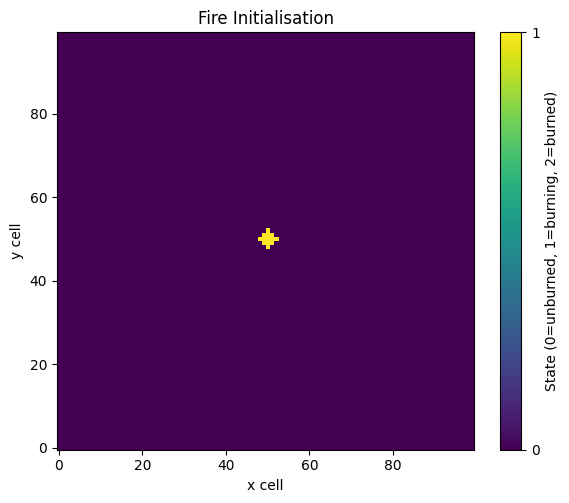

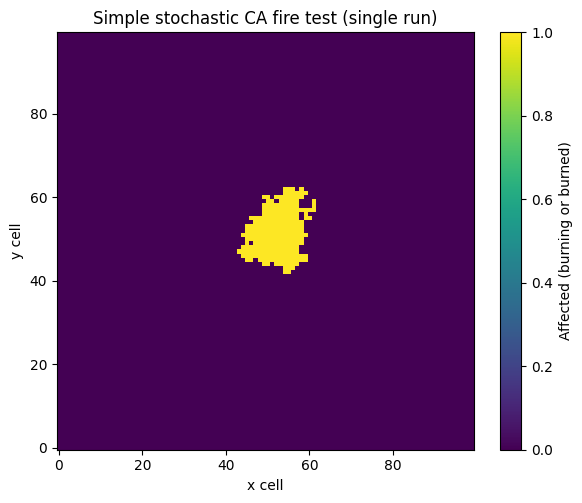

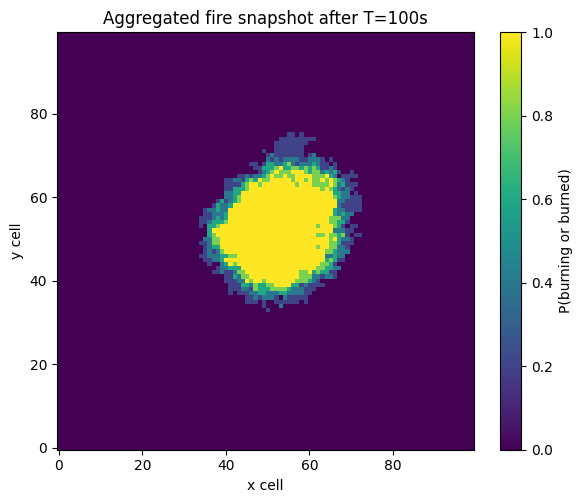

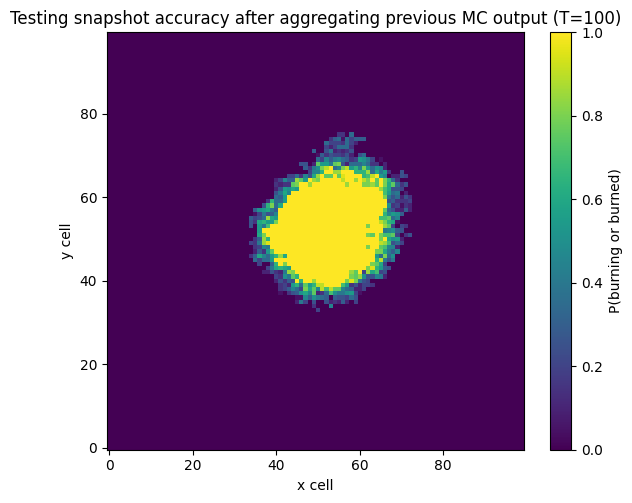

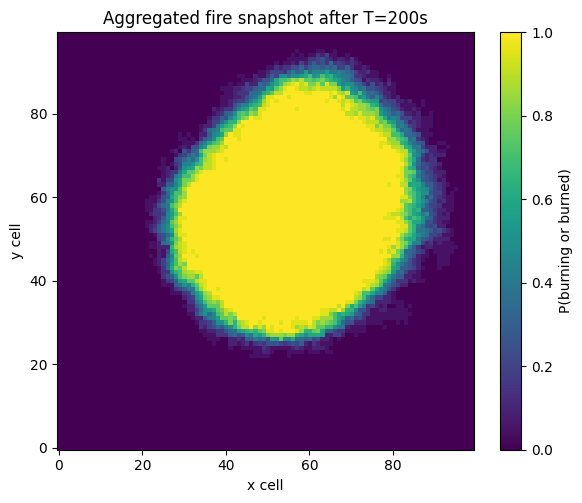

In [248]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=3, center=(50, 50), radius_km=0.2)

model.plot_firestate(state, title="Fire Initialisation")

for _ in range(60):
    model.step_batch(state, ros_mps=2, wind_coeff=0.6, diag=True)

model.plot_firestate(state,  kind="p_affected", title="Simple stochastic CA fire test (single run)")


fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Testing snapshot accuracy after aggregating previous MC output (T=100)")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")

with retardant barrier:


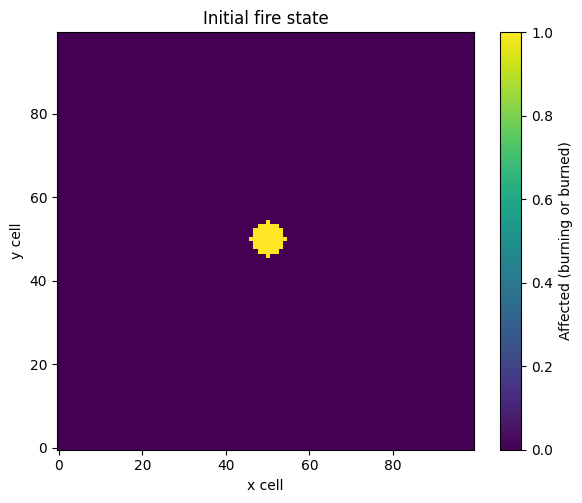

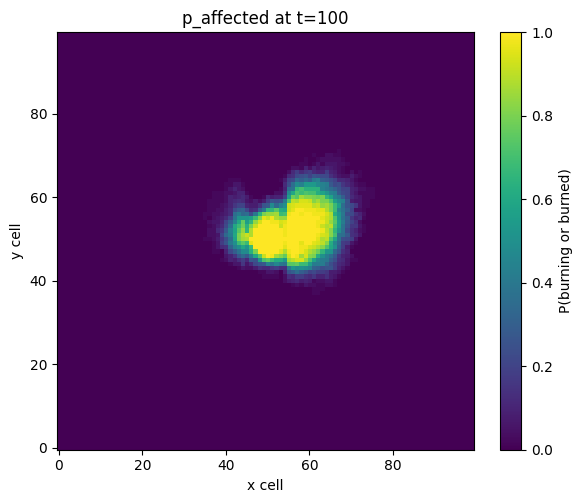

without retardant barrier:
with retardant barrier:


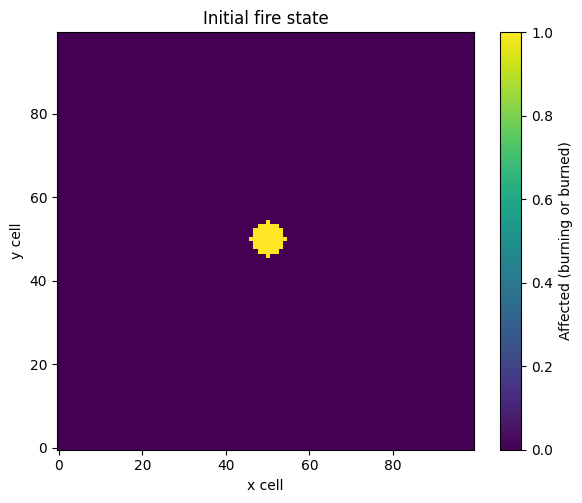

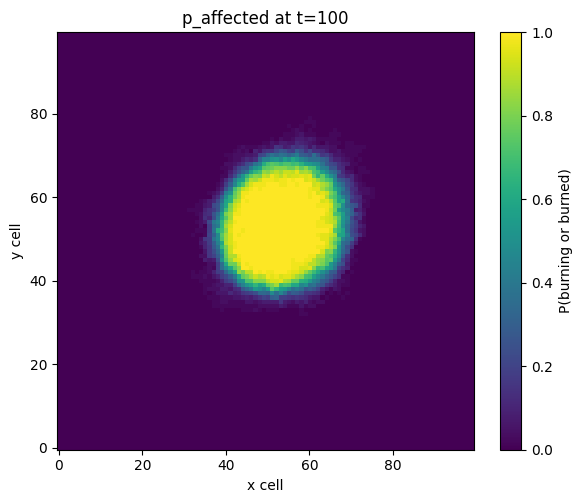

In [159]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 100, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)
state.retardant[:, 45:55, 20:80] = 2.0  # barrier

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")
#model.plot_firestate(state, kind="retardant", title="Initial retardant barrier")


for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")
#model.plot_firestate(agg, kind="retardant")

print('without retardant barrier:')

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")

for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")

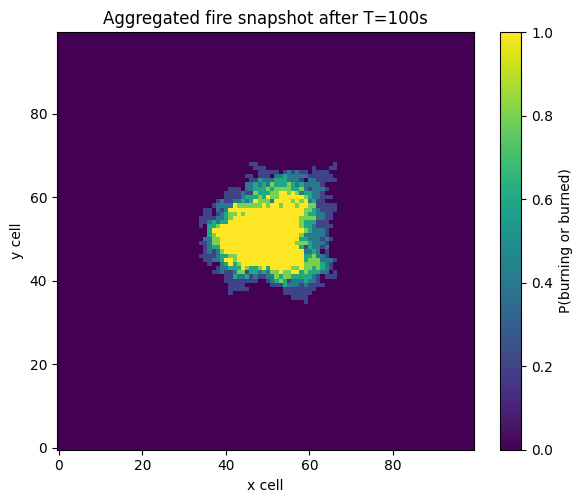

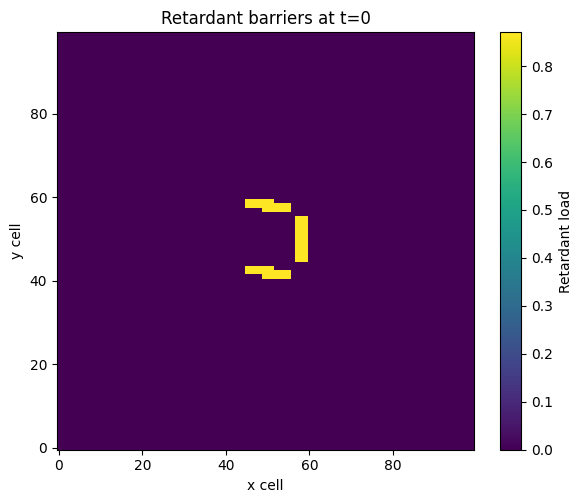

'updated_fire_snapshot = model.simulate_from_firestate(\n    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")\n\nreupdated_fire_snapshot = model.simulate_from_firestate(\n    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")'

In [171]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 1
wind[..., 1] = 1

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

model.plot_firestate(fire_snapshot, kind="retardant", title="Retardant barriers at t=0")


"""updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")"""

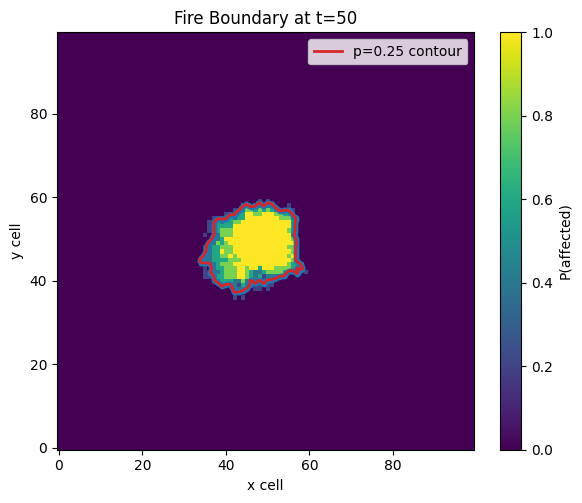

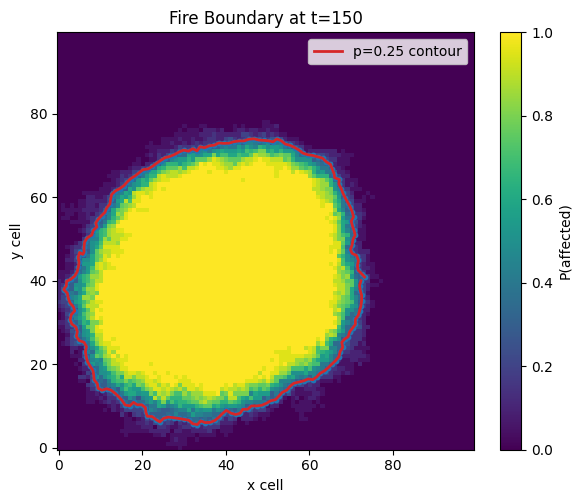

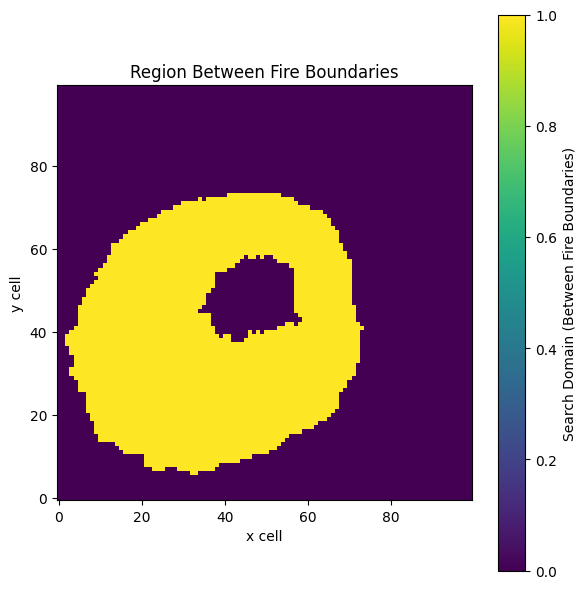

In [250]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = -3
wind[..., 1] = -3

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_evolved = model.simulate_from_ignition(
    T=50, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

init_boundary = extract_fire_boundary(
    fire_evolved,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_evolved,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

updated_fire = model.simulate_from_firestate(
    fire_evolved, T=150, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

final_boundary = extract_fire_boundary(
    updated_fire,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    updated_fire,
    final_boundary,
    field="affected",
    title="Fire Boundary at t=150"
)

x = model.discretise_between_boundaries(
    init_fire_boundary=init_boundary,
    final_fire_boundary=final_boundary)

model.plot_search_domain(x)

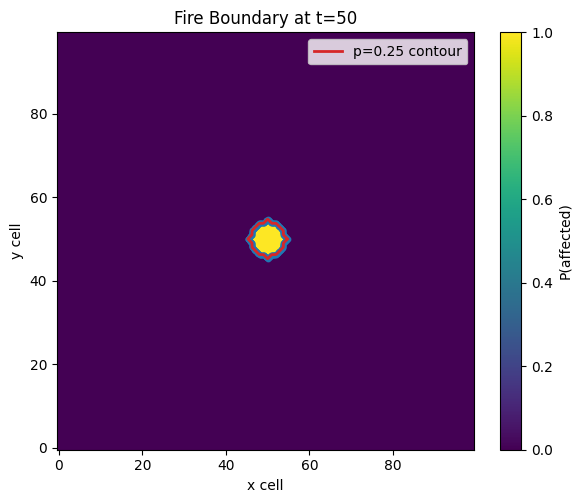

In [ ]:
### Testing that fire boundary works at initialisation
model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

init_boundary = extract_fire_boundary(
    state,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    state,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

#### Testing:

#### Fire Boundary Mechanisms

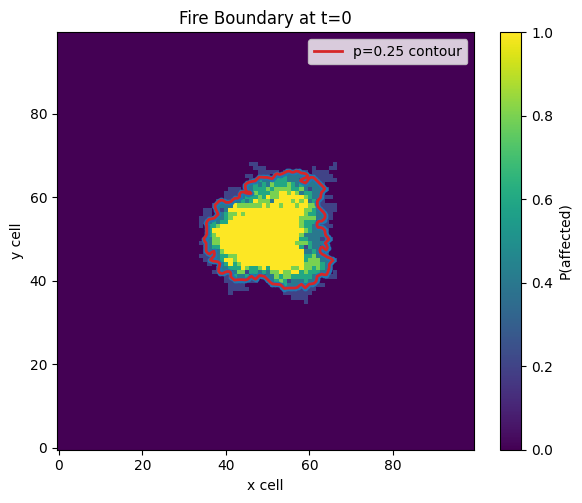

In [187]:
extracted_boundary = extract_fire_boundary(
    fire_snapshot,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_snapshot,
    extracted_boundary,
    field="affected",
    title="Fire Boundary at t=0"
)

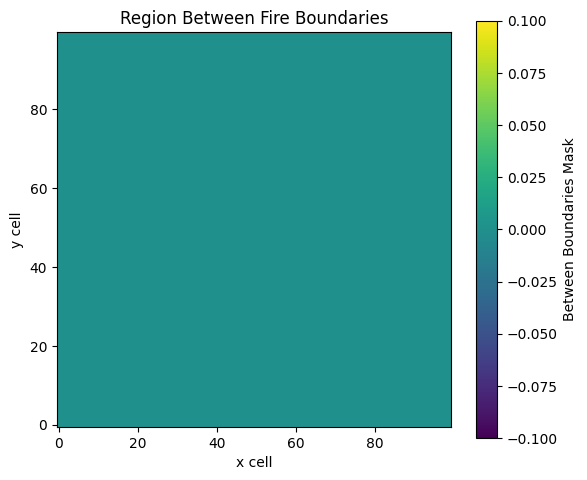

In [244]:
x = model.discretise_between_boundaries(
    init_fire_boundary=extracted_boundary,
    final_fire_boundary=extracted_boundary)

#plot a 2d map of the region between boundaries
plt.figure(figsize=(6, 5))
im = plt.imshow(x.T, origin="lower", aspect="equal")
plt.colorbar(im, label="Between Boundaries Mask")
plt.xlabel("x cell")
plt.ylabel("y cell")
plt.title("Region Between Fire Boundaries")
plt.tight_layout()
plt.show()

#### Fire boundary map (connecting between fire boundaries)

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.path import Path

# ---------- masks ----------
def _polygon_inside_mask(poly_xy: np.ndarray, grid_size: tuple[int, int]) -> np.ndarray:
    nx, ny = grid_size
    X = np.arange(nx)[:, None]
    Y = np.arange(ny)[None, :]
    pts = np.stack([np.broadcast_to(X, (nx, ny)).ravel(),
                    np.broadcast_to(Y, (nx, ny)).ravel()], axis=1)
    path = Path(poly_xy, closed=True)
    return path.contains_points(pts).reshape(nx, ny)

def _rasterize_polyline_cells(poly_xy: np.ndarray, grid_size: tuple[int, int], step: float = 0.25) -> np.ndarray:
    nx, ny = grid_size
    mask = np.zeros((nx, ny), dtype=bool)
    K = poly_xy.shape[0]
    for i in range(K):
        a = poly_xy[i]
        b = poly_xy[(i + 1) % K]
        seg_len = float(np.hypot(*(b - a)))
        n = max(2, int(np.ceil(seg_len / step)))
        ts = np.linspace(0.0, 1.0, n)
        pts = a[None, :] * (1 - ts)[:, None] + b[None, :] * ts[:, None]
        xi = np.clip(np.round(pts[:, 0]).astype(int), 0, nx - 1)
        yi = np.clip(np.round(pts[:, 1]).astype(int), 0, ny - 1)
        mask[xi, yi] = True
    return mask

# ---------- Laplace solve (SOR) ----------
def _solve_laplace_dirichlet_sor(
    region_mask: np.ndarray,
    bc0_mask: np.ndarray, bc0_val: float,
    bc1_mask: np.ndarray, bc1_val: float,
    *,
    omega: float = 1.9,
    max_iters: int = 8000,
    tol: float = 1e-5,
) -> np.ndarray:
    nx, ny = region_mask.shape
    psi = np.zeros((nx, ny), dtype=float)
    psi[region_mask] = 0.5
    psi[bc0_mask] = bc0_val
    psi[bc1_mask] = bc1_val

    unknown = region_mask & (~bc0_mask) & (~bc1_mask)
    if not np.any(unknown):
        return psi

    # iterate only on interior indices (avoid boundaries)
    xs, ys = np.where(unknown)
    for _ in range(max_iters):
        maxdiff = 0.0
        for x, y in zip(xs, ys):
            if x == 0 or x == nx - 1 or y == 0 or y == ny - 1:
                continue
            new = 0.25 * (psi[x+1, y] + psi[x-1, y] + psi[x, y+1] + psi[x, y-1])
            upd = (1 - omega) * psi[x, y] + omega * new
            diff = abs(upd - psi[x, y])
            if diff > maxdiff:
                maxdiff = diff
            psi[x, y] = upd

        psi[bc0_mask] = bc0_val
        psi[bc1_mask] = bc1_val
        if maxdiff < tol:
            break

    return psi

# ---------- bilinear sampling ----------
def _bilinear_sample(F: np.ndarray, x: float, y: float) -> float:
    nx, ny = F.shape
    x = float(np.clip(x, 0.0, nx - 1.001))
    y = float(np.clip(y, 0.0, ny - 1.001))
    x0 = int(np.floor(x)); y0 = int(np.floor(y))
    x1 = min(x0 + 1, nx - 1); y1 = min(y0 + 1, ny - 1)
    tx = x - x0; ty = y - y0
    f00 = F[x0, y0]; f10 = F[x1, y0]
    f01 = F[x0, y1]; f11 = F[x1, y1]
    return (1-tx)*(1-ty)*f00 + tx*(1-ty)*f10 + (1-tx)*ty*f01 + tx*ty*f11

def _bilinear_sample_vec(Fx: np.ndarray, Fy: np.ndarray, x: float, y: float) -> np.ndarray:
    return np.array([_bilinear_sample(Fx, x, y), _bilinear_sample(Fy, x, y)], dtype=float)

# ---------- equal-flux resampling on boundary0 ----------
def _resample_polyline_equal_flux(p: np.ndarray, w: np.ndarray, K: int) -> np.ndarray:
    """
    p: (N,2) closed polyline
    w: (N,) nonnegative weights evaluated at p
    Returns K points, ordered, approximately equal ∫ w ds spacing.
    """
    N = p.shape[0]
    p_next = p[(np.arange(N) + 1) % N]
    seg = np.linalg.norm(p_next - p, axis=1)  # (N,)
    w_next = w[(np.arange(N) + 1) % N]
    w_avg = 0.5 * (w + w_next)

    # cumulative "flux length"
    q = w_avg * seg
    Q = np.concatenate([[0.0], np.cumsum(q)])   # length N+1
    Qtot = Q[-1]
    if Qtot <= 1e-12:
        # fallback to uniform arc-length if weights degenerate
        s = np.linspace(0.0, 1.0, K, endpoint=False)
        idx = (s * N).astype(int)
        return p[idx].copy()

    targets = np.linspace(0.0, Qtot, K, endpoint=False)
    out = np.zeros((K, 2), dtype=float)

    # walk segments
    j = 0
    for i, T in enumerate(targets):
        while j < N and Q[j+1] < T:
            j += 1
        # interpolate within segment j
        if j >= N:
            j = N - 1
        if Q[j+1] <= Q[j] + 1e-12:
            alpha = 0.0
        else:
            alpha = (T - Q[j]) / (Q[j+1] - Q[j])
        out[i] = (1 - alpha) * p[j] + alpha * p_next[j]
    return out

# ---------- streamline trace + arc-length resample ----------
def _trace_streamline(psi, gx, gy, x0, y0, *, step=0.5, max_steps=4000, grad_eps=1e-8):
    pts = [(float(x0), float(y0))]
    psi_curr = _bilinear_sample(psi, x0, y0)

    x, y = float(x0), float(y0)
    for _ in range(max_steps):
        if psi_curr >= 1.0 - 1e-3:
            break
        g = _bilinear_sample_vec(gx, gy, x, y)
        nrm = float(np.hypot(g[0], g[1]))
        if nrm < grad_eps:
            break
        v = g / nrm
        x2 = x + step * v[0]
        y2 = y + step * v[1]
        psi2 = _bilinear_sample(psi, x2, y2)
        # if numerical wobble makes psi decrease, damp
        if psi2 < psi_curr:
            x2 = x + 0.25 * step * v[0]
            y2 = y + 0.25 * step * v[1]
            psi2 = _bilinear_sample(psi, x2, y2)
        pts.append((x2, y2))
        x, y, psi_curr = x2, y2, psi2

    return np.asarray(pts, dtype=float)

def _resample_polyline_by_arclength(poly: np.ndarray, M: int) -> np.ndarray:
    d = np.diff(poly, axis=0)
    seg = np.hypot(d[:, 0], d[:, 1])
    L = float(np.sum(seg))
    if L <= 1e-12:
        return np.broadcast_to(poly[-1], (M, 2)).copy()
    s = np.concatenate([[0.0], np.cumsum(seg)])  # length len(poly)
    targets = np.linspace(0.0, L, M)
    x = np.interp(targets, s, poly[:, 0])
    y = np.interp(targets, s, poly[:, 1])
    return np.stack([x, y], axis=1)

# ---------- map object ----------
@dataclass(frozen=True)
class HarmonicStripMap:
    t0: int
    t1: int
    p_boundary: float
    s_grid: np.ndarray        # (K,) in [0,1)
    d_grid: np.ndarray        # (M,) in [0,1] (now *distance fraction* along streamline)
    xy: np.ndarray            # (K,M,2)
    theta: np.ndarray         # (K,M), 0=vertical
    psi: np.ndarray           # (nx,ny)

def build_harmonic_strip_map_uniform(
    boundary0,
    boundary1,
    *,
    grid_size: tuple[int, int],
    M: int = 60,
    streamline_step: float = 0.5,
    seed_mode: str = "equal_flux",     # "equal_flux" | "arclength"
    omega: float = 1.9,
    laplace_max_iters: int = 8000,
    laplace_tol: float = 1e-5,
    grad_eps: float = 1e-8,
) -> HarmonicStripMap:
    """
    Produces non-intersecting streamlines (s-lines) that more uniformly fill the strip:
      - seeds on boundary0 chosen by equal flux (|∇ψ| ds) by default
      - d coordinate uses fractional arc-length along each streamline (uniform physical spacing)
    """
    p0 = np.asarray(boundary0.xy, dtype=float)
    p1 = np.asarray(boundary1.xy, dtype=float)
    if p0.shape != p1.shape:
        raise ValueError(f"Boundaries must have same shape (same K). Got {p0.shape} vs {p1.shape}")
    K = p0.shape[0]

    inside0 = _polygon_inside_mask(p0, grid_size)
    inside1 = _polygon_inside_mask(p1, grid_size)
    # pick outer/inner by area
    if inside0.sum() >= inside1.sum():
        outer, inner = inside0, inside1
        bc_outer, bc_inner = p0, p1
    else:
        outer, inner = inside1, inside0
        bc_outer, bc_inner = p1, p0

    region = outer & (~inner)

    bc0_mask = _rasterize_polyline_cells(p0, grid_size, step=0.25)
    bc1_mask = _rasterize_polyline_cells(p1, grid_size, step=0.25)

    psi = _solve_laplace_dirichlet_sor(
        region_mask=region,
        bc0_mask=bc0_mask, bc0_val=0.0,
        bc1_mask=bc1_mask, bc1_val=1.0,
        omega=omega,
        max_iters=laplace_max_iters,
        tol=laplace_tol,
    )

    gx, gy = np.gradient(psi)

    # choose seeds on boundary0
    if seed_mode == "equal_flux":
        # weight = |∇ψ| on boundary0 points
        w = np.array([np.hypot(*_bilinear_sample_vec(gx, gy, p0[i, 0], p0[i, 1])) for i in range(K)], dtype=float)
        w = np.maximum(w, 1e-6)
        seeds = _resample_polyline_equal_flux(p0, w, K)
        s_grid = np.linspace(0.0, 1.0, K, endpoint=False)  # s now corresponds to equal-flux coordinate
    elif seed_mode == "arclength":
        seeds = p0.copy()
        s_grid = np.linspace(0.0, 1.0, K, endpoint=False)
    else:
        raise ValueError("seed_mode must be 'equal_flux' or 'arclength'")

    d_grid = np.linspace(0.0, 1.0, M)

    xy = np.zeros((K, M, 2), dtype=float)
    for i in range(K):
        poly = _trace_streamline(
            psi, gx, gy,
            seeds[i, 0], seeds[i, 1],
            step=streamline_step,
            max_steps=4000,
            grad_eps=grad_eps,
        )
        xy[i] = _resample_polyline_by_arclength(poly, M)

    # orientation along streamline: forward diff in d
    dxy = np.diff(xy, axis=1, prepend=xy[:, :1, :])
    theta = np.arctan2(dxy[:, :, 0], dxy[:, :, 1] + 1e-12)  # 0=vertical

    return HarmonicStripMap(
        t0=int(boundary0.t),
        t1=int(boundary1.t),
        p_boundary=float(boundary0.p_boundary),
        s_grid=s_grid,
        d_grid=d_grid,
        xy=xy,
        theta=theta,
        psi=psi,
    )


def plot_strip_map(
    boundary0,
    boundary1,
    strip: HarmonicStripMap,
    *,
    stride_s: int = 10,     # plot every stride_s-th streamline
    show_psi: bool = False,
    title: str | None = None,
):
    p0 = np.asarray(boundary0.xy, dtype=float)
    p1 = np.asarray(boundary1.xy, dtype=float)

    plt.figure(figsize=(7, 7))

    if show_psi:
        im = plt.imshow(strip.psi.T, origin="lower", aspect="equal", vmin=0.0, vmax=1.0)
        plt.colorbar(im, label="ψ (harmonic)")

    # boundaries
    plt.plot(p0[:, 0], p0[:, 1], linewidth=2, label="Boundary 0")
    plt.plot(p1[:, 0], p1[:, 1], linewidth=2, label="Boundary 1")

    # connecting lines (streamlines)
    K = strip.xy.shape[0]
    for i in range(0, K, max(1, int(stride_s))):
        pts = strip.xy[i]  # (M,2)
        plt.plot(pts[:, 0], pts[:, 1], linewidth=1)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.title(title if title is not None else f"Streamlines between boundaries (stride={stride_s})")
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np

def sd_to_xy_theta(strip: HarmonicStripMap, s, d, *, delta: float | None = None):
    """
    Map (s,d) -> (x,y) and local streamline orientation theta at that point.
    theta=0 means vertically aligned (+y direction).

    s in [0,1) periodic, d in [0,1].
    """
    def sd_to_xy(strip, s, d):
        s = np.asarray(s, dtype=float)
        d = np.asarray(d, dtype=float)

        K, M = strip.xy.shape[0], strip.xy.shape[1]
        s = np.mod(s, 1.0)
        d = np.clip(d, 0.0, 1.0)

        us = s * K
        i0 = np.floor(us).astype(int)
        a = us - i0
        i1 = (i0 + 1) % K

        ud = d * (M - 1)
        j0 = np.floor(ud).astype(int)
        b = ud - j0
        j1 = np.clip(j0 + 1, 0, M - 1)

        p00 = strip.xy[i0, j0]
        p10 = strip.xy[i1, j0]
        p01 = strip.xy[i0, j1]
        p11 = strip.xy[i1, j1]

        a_ = a[..., None]
        b_ = b[..., None]
        return (1 - a_) * (1 - b_) * p00 + a_ * (1 - b_) * p10 + (1 - a_) * b_ * p01 + a_ * b_ * p11

    xy = sd_to_xy(strip, s, d)

    # finite-difference tangent along the streamline direction (increasing d)
    M = strip.xy.shape[1]
    if delta is None:
        delta = 0.5 / (M - 1)  # half a grid step in d

    d0 = np.clip(np.asarray(d, dtype=float) - delta, 0.0, 1.0)
    d1 = np.clip(np.asarray(d, dtype=float) + delta, 0.0, 1.0)

    xy0 = sd_to_xy(strip, s, d0)
    xy1 = sd_to_xy(strip, s, d1)

    t = xy1 - xy0  # tangent vector
    theta = np.arctan2(t[..., 0], t[..., 1])  # 0 = vertical
   #theta = (theta + np.pi/2) % (2*np.pi)

    return xy, theta


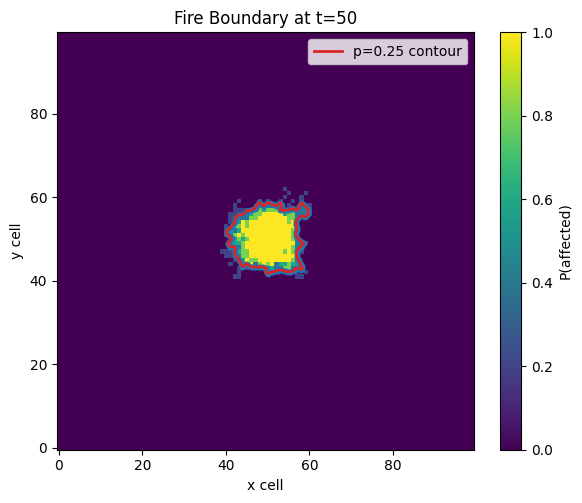

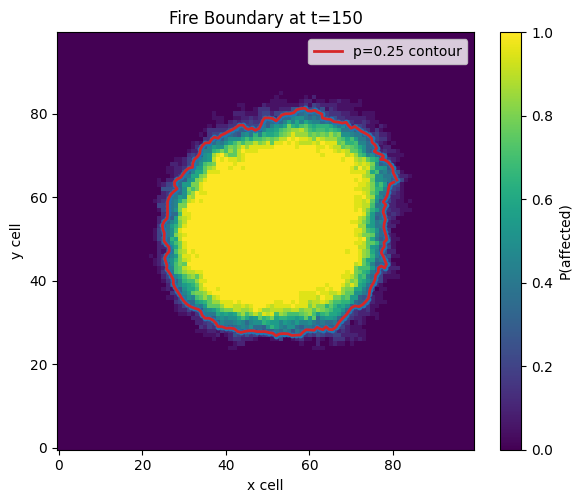

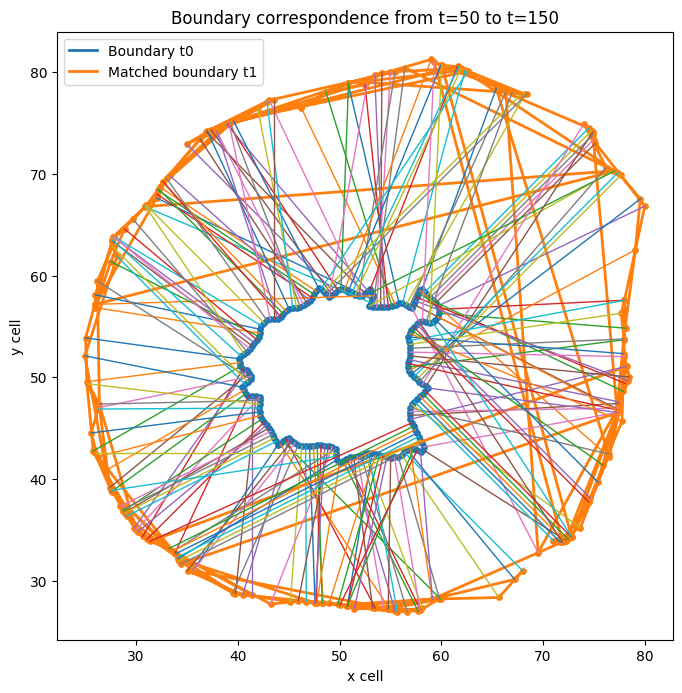

BoundaryMap(t0=50, t1=200, K=200, p_boundary=0.25, s=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.

In [210]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 1
wind[..., 1] = 1

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_evolved = model.simulate_from_ignition(
    T=50, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

init_boundary = extract_fire_boundary(
    fire_evolved,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_evolved,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

updated_fire = model.simulate_from_firestate(
    fire_evolved, T=150, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

final_boundary = extract_fire_boundary(
    updated_fire,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)


plot_fire_boundary(
    updated_fire,
    final_boundary,
    field="affected",
    title="Fire Boundary at t=150"
)

plot_boundary_correspondence(
    init_boundary,
    final_boundary,
    stride=1,
    show_points=True,
    title="Boundary correspondence from t=50 to t=150"
)

#model.plot_firestate(fire_evolved, kind="p_affected", title="Fire at t=50")

#model.plot_firestate(updated_fire, kind="p_affected", title="Fire at t=150")

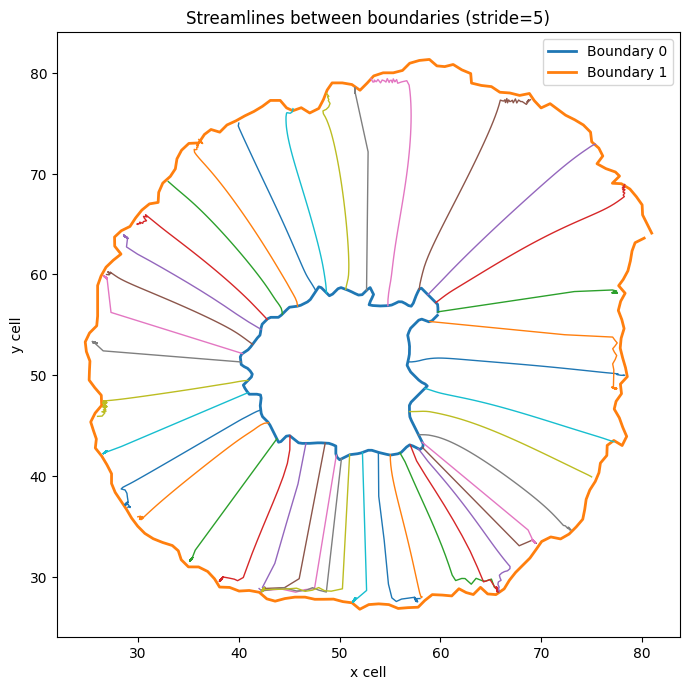

(array([77.029813  , 58.17954012]), np.float64(-1.5707963754714482))

In [232]:
# boundary0 = extract_fire_boundary(fire0, K=200, p_boundary=0.5, anchor="max_x", ccw=True)
# boundary1 = extract_fire_boundary(fire1, K=200, p_boundary=0.5, anchor="max_x", ccw=True)

strip = build_harmonic_strip_map_uniform(
    init_boundary, final_boundary,
    grid_size=model.env.grid_size,   # important: use your env grid
    M=60,
    seed_mode="equal_flux",
    streamline_step=0.5,
)

plot_strip_map(init_boundary, final_boundary, strip, stride_s=5, show_psi=False)

# Query example
xy,theta = sd_to_xy_theta(strip, s=0, d=1)     # (2,) point in cell coords

xy,theta

In [ ]:
# boundary0 = extract_fire_boundary(fire0, K=200, p_boundary=0.5, anchor="max_x", ccw=True)
# boundary1 = extract_fire_boundary(fire1, K=200, p_boundary=0.5, anchor="max_x", ccw=True)

bm = build_boundary_map(init_boundary, final_boundary)

# Query a point halfway between boundaries at s=0.3
xy = bm.xy(s_query=0.3, d_query=0.5)      # returns shape (2,) here
theta = bm.theta(0.3)                      # orientation, 0=vertical

# Discrete velocity at the K sample points (future use)
v_i = bm.p1 - bm.p0                        # (K,2)
theta_i = bm.theta_i                       # (K,)

In [197]:
bm.xy(s_query=0, d_query=1)

array([78.1630698 , 54.82935333])

In [194]:
v_i

array([[ 18.4130698 ,  -1.46632781],
       [ 18.25437554,   0.90482334],
       [ 20.29035105,   9.78988238],
       [ 15.71176816,  15.71176816],
       [ 15.79597561,  15.79597561],
       [ 16.0058814 ,  16.0058814 ],
       [ 16.125     ,  16.125     ],
       [ 16.125     ,  16.125     ],
       [  7.29660908,  19.75525594],
       [ 18.60433829, -16.38213106],
       [ 20.1741827 ,  -9.59661025],
       [ 20.51982214,  -8.47166493],
       [ 20.90970702,  -7.84114013],
       [ 19.97907479, -10.27501088],
       [ 12.41778565, -24.07558433],
       [  9.5031532 ,  21.12489911],
       [ 11.71221251,  20.71700749],
       [  6.15463917,  22.91843683],
       [ -5.00041561,  21.60429773],
       [ -9.27685436,  19.38847669],
       [ -6.49486192,  21.07286691],
       [ -2.2916096 ,  21.84314604],
       [ -0.95106751,  22.82562017],
       [  0.12143546,  23.07148191],
       [  1.32544747,  23.10373385],
       [  3.14197113,  23.50446281],
       [ 24.03704318,  13.30614386],
 